## Reddit Topic Classification Using LLM

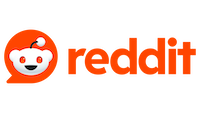

In [13]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import praw
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers.schedules import PolynomialDecay

In [2]:
tf.__version__

'2.9.0'

#### For this task, we'll use Reddit posts using web scraping and will obtain posts of 2 subreddits, viz. ProLife(label 0) and ProChoice(label 1), that will also serve as the 2 categories for text classification.

In [3]:
reddit = praw.Reddit(client_id='9NWKSFAWSKmwZYVaiEgQmQ', 
                     client_secret='re63PZcwTihivGp6T8P8hOCKWJcskw', 
                     user_agent='aml')

In [4]:
def get_subreddit_hot_posts(subreddits):
    posts = []
    for subreddit in subreddits:
        for post in reddit.subreddit(subreddit).hot(limit=2000):
            posts.append([post.selftext, subreddit, subreddits[subreddit]])
    posts = pd.DataFrame(posts,columns=['body', 'subreddit', 'label'])
    posts['num_words'] = posts['body'].map(lambda post: len(post.split()))
    posts = posts[posts['num_words'] >= 20]

    return posts

In [5]:
def get_category_details(posts_df):
    for subreddit in posts_df['subreddit'].unique():
        subreddit_df = posts_df[posts_df["subreddit"] == subreddit]
        print(f'Category: {subreddit}')
        print('{0:<25}'.format(f'Number of examples in category = {len(subreddit_df)}'))
        print('{0:<25}'.format(f'Number of words in category = {sum(subreddit_df["num_words"])}'))
        print()

In [6]:
reddit_df = get_subreddit_hot_posts({'ProLife': 0, 'ProChoice': 1})
get_category_details(reddit_df)

Category: ProLife
Number of examples in category = 386
Number of words in category = 60186

Category: ProChoice
Number of examples in category = 286
Number of words in category = 53321



In [7]:
print('Total number of words in dataset =', sum(reddit_df['num_words']))

Total number of words in dataset = 113507


In [8]:
reddit_df.head()

,body,subreddit,label,num_words
0,The sub needs to have resources so that women ...,ProLife,0,53
1,Good Wednesday Pro-Lifers! During these distre...,ProLife,0,122
4,"Aight so basically I think I fucked up,I’m 15,...",ProLife,0,202
6,On Saturday I found out that I'm pregnant with...,ProLife,0,60
9,"When Roe V. Wade was overturned, I saw an actr...",ProLife,0,82


In [9]:
reddit_df.sample(5).to_dict()

{'body': {273: 'I thought this would be an interesting way for different people to explore their own arguments, as well as the other sides, in a better and more constructive way. Hopefully it works! \n\nFlipping the question. For me, I believe the best pro life argument is that everyone has a right to life and it should start as early as possible. I think the worst pro choice argument is that our bodily autonomy extents to killing people who are in their situation due to their actions. The whole kidnapping someone, putting them in your house, and killing them for being in your house type of arguments.',
  1073: 'I live pretty close to my state Capitol and I’m pretty sure people will be protesting there. Especially since it’s a Friday night. And they were there when Roe was overturned. \n\nAny thoughts on this? It definitely sends a message even if there is much work to do. \n\nThoughts?',
  841: 'When I\'m "debating" pro choicers and pro aborties they always bring up some bullshit abou

In [83]:
reddit_df.to_csv('reddit-dataset.csv')

### Splitting the dataset into training (at least 160 examples) and test (at least 40 examples) sets.

In [12]:
reddit_ds = Dataset.from_pandas(reddit_df)
reddit_ds

Dataset({
    features: ['body', 'subreddit', 'label', 'num_words', '__index_level_0__'],
    num_rows: 672
})

In [16]:
reddit_ds = reddit_ds.shuffle()

train_testvalid = reddit_ds.train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
reddit_ds = DatasetDict({
    'train': train_testvalid['train'],
    'valid': test_valid['train'],
    'test': test_valid['test']
})

reddit_ds

DatasetDict({
    train: Dataset({
        features: ['body', 'subreddit', 'label', 'num_words', '__index_level_0__'],
        num_rows: 537
    })
    valid: Dataset({
        features: ['body', 'subreddit', 'label', 'num_words', '__index_level_0__'],
        num_rows: 67
    })
    test: Dataset({
        features: ['body', 'subreddit', 'label', 'num_words', '__index_level_0__'],
        num_rows: 68
    })
})

In [17]:
for split in reddit_ds:
    category_example_count = reddit_ds[split].to_pandas()['subreddit'].value_counts()
    print(f'Set: {split}')
    print('{0:<12}'.format('Category'), '{0:<12}'.format('Examples'))
    print(category_example_count)
    print('Total Number of Examples =', sum(category_example_count))
    print()

Set: train
Category     Examples    
ProLife      309
ProChoice    228
Name: subreddit, dtype: int64
Total Number of Examples = 537

Set: valid
Category     Examples    
ProLife      37
ProChoice    30
Name: subreddit, dtype: int64
Total Number of Examples = 67

Set: test
Category     Examples    
ProLife      40
ProChoice    28
Name: subreddit, dtype: int64
Total Number of Examples = 68



#### Let's use the pretrained BERT language model for text classification of the dataset prepared in previous steps.

In [18]:
checkpoint = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [19]:
def tokenize(posts):
    return tokenizer(posts['body'], truncation=True)

In [20]:
tokenized_ds = reddit_ds.map(tokenize, batched=True)

In [21]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

In [22]:
train_ds = tokenized_ds['train'].to_tf_dataset(
    columns=['attention_mask', 'input_ids'],
    label_cols=['label'],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator
)

valid_ds = tokenized_ds['valid'].to_tf_dataset(
    columns=['attention_mask', 'input_ids',],
    label_cols=['label'],
    shuffle=False,
    batch_size=32,
    collate_fn=data_collator
)

test_ds = tokenized_ds['test'].to_tf_dataset(
    columns=['attention_mask', 'input_ids',],
    label_cols=['label'],
    shuffle=False,
    batch_size=32,
    collate_fn=data_collator
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-26 09:27:28.161259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-26 09:27:28.161400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
num_epochs = 5

num_train_steps = len(train_ds) * num_epochs

lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5,
    end_learning_rate=0.0,
    decay_steps=num_train_steps
)

optim = keras.optimizers.Adam(learning_rate=lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

history = model.fit(train_ds, validation_data=valid_ds, epochs=num_epochs, workers=7, use_multiprocessing=True)

Epoch 1/5


2023-04-26 09:34:37.655977: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-26 09:34:45.645375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 0.7001 - accuracy: 0.5233 

2023-04-26 09:47:06.417814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 760s 45s/step - loss: 0.7001 - accuracy: 0.5233 - val_loss: 0.6805 - val_accuracy: 0.7164
Epoch 2/5
17/17 [==============================] - 741s 44s/step - loss: 0.6992 - accuracy: 0.5102 - val_loss: 0.6528 - val_accuracy: 0.6866
Epoch 3/5
17/17 [==============================] - 737s 43s/step - loss: 0.6287 - accuracy: 0.6238 - val_loss: 0.5696 - val_accuracy: 0.7463
Epoch 4/5
17/17 [==============================] - 727s 43s/step - loss: 0.5121 - accuracy: 0.7505 - val_loss: 0.5857 - val_accuracy: 0.7463
Epoch 5/5
17/17 [==============================] - 764s 45s/step - loss: 0.4112 - accuracy: 0.8287 - val_loss: 0.5468 - val_accuracy: 0.7761


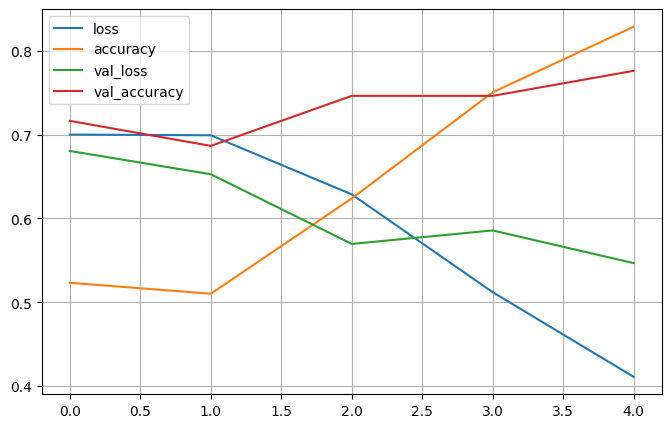

In [26]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

#### Evaluating the model on test set

In [27]:
model.evaluate(test_ds)

3/3 [==============================] - 8s 3s/step - loss: 0.7497 - accuracy: 0.6324


[0.7496947646141052, 0.6323529481887817]

In [81]:
test_set_y = np.array([])
test_set_y_hat = np.array([])
test_posts = np.array([])

for x,y in test_ds:
    for i in range(len(x['input_ids'])):
        unpadded_seq = tf.boolean_mask(x['input_ids'][i], x['attention_mask'][i])
        decoded_text = tokenizer.decode(unpadded_seq)
        test_posts = np.append(test_posts, decoded_text)
    test_set_y = np.append(test_set_y, y.numpy())
    test_set_predictions = model.predict(x)['logits']
    test_set_y_hat = np.append(test_set_y_hat, np.argmax(test_set_predictions, axis=1))

1/1 [==============================] - 1s 806ms/step


#### Few examples of test set classification

In [82]:
label_category = {0:'ProLife', 1:'ProChoice'}

for i in range(5):
    print(f'Post {i+1}:', test_posts[i], sep='\n')
    print(f'Actual category: {label_category[int(test_set_y[i])]}({int(test_set_y[i])})')
    print(f'Predicted category: {label_category[int(test_set_y_hat[i])]}({int(test_set_y_hat[i])})')
    print()

Post 1:
[CLS] Thus far I have Leslie J Reagan ’ s “ When Abortion Was a Crime ”, but I was hoping to find other books that also had a comprehensive historical examination of abortion. Other books that supposedly do this are written by pro - life authors, so I hesitate to read those on account of the kind of rhetoric they might engage in. Does anyone have any suggestions? Thank you! [SEP]
Actual category: ProChoice(1)
Predicted category: ProLife(0)

Post 2:
[CLS] Good Wednesday Pro - Lifers! During these distressing times we can get very frustrated with ourselves, friends families and even society. Fret not, because this post is dedicated to you guys discussing a wide range of topics outside of abortions if you need too. Topics such as movies, sports, hobbies, current events or major events happening in the world and maybe even other politics if you choose too. This chat is your escape, to talk about other things as well and to further connect with other members of Pro - life. You are n

In [70]:
misclassified = sum(test_set_y != test_set_y_hat)
print(f'Number of posts in test set = {reddit_ds.num_rows["test"]}')
print(f'Number of correctly classified posts = {reddit_ds.num_rows["test"] - misclassified}')
print(f'Number of incorrectly classified posts = {misclassified}')

Number of posts in test set = 68
Number of correctly classified posts = 43
Number of incorrectly classified posts = 25


### Observations:
- Even though we fine-tuned a pretrained model, the test accuracy is quite low as compared to an expected accuracy which can be due to the small amount of training data that might be insufficient for the complex task of predicting the category/class/subreddit of each post.

### Scope of Improvement:
- If we fine-tune the model with a larger dataset, the model can learn from more varied examples and an improvement in accuracy can be achieved.
- We can also clean dataset to even more extent such that it ensures that the posts/examples used for training the model are actually relevant to their respective categories and also are correlated with other posts of same category but that will require a lot of human effort to do so.
- Depending on the availability of computing resources, Hyperparameters of the model can be tuned and the model can be trained for more epochs to gain slight improvement in accuracy.

### References
- Aurlien Gron. 2017. Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed.). O’Reilly Media, Inc
- https://towardsdatascience.com/scraping-reddit-data-1c0af3040768
- https://huggingface.co/learn/nlp-course/chapter3/3?fw=tf